In [6]:
import numpy as np
import pandas as pd
#读取数据集
credit = pd.read_csv('./Q1data/credit_card.csv', encoding='gb18030')
print('原始数据的形状为：', credit.shape)
#数据预处理
#去除使用频率为5且月刷卡金额不为1的异常数据
index1 = credit['频率'] == 5
index2 = credit['月刷卡额'] != 1
Index1 = index1 & index2
credit1 = credit.loc[Index1 == False,:]
print('删除第一种异常数据后，数据的形状为：', credit1.shape)
#去除逾期、呆账、退票、强制停卡、拒往记录为1，但瑕疵户记录为2的数据
indexSec1 = credit1['逾期'] == 1
indexSec2 = credit1['呆账'] == 1
indexSec3 = credit1['退票'] == 1
indexSec4 = credit1['强制停卡记录'] == 1
indexSec5 = credit1['拒往记录'] == 1
indexSec6 = credit1['瑕疵户'] == 2
Index2 = indexSec1 & indexSec2 & indexSec3 & indexSec4 & indexSec5 & indexSec6
credit2 = credit1.loc[Index2 == False,:]
print('删除第二种异常数据后，数据的形状为：', credit2.shape)
#去除呆账（逾期且经过追讨无法收回）、强制停卡、退票都为1，但拒往记录为2的数据
indexThird1 = credit2['拒往记录'] == 2
Index3 = indexSec2 & indexSec4 & indexSec3 & indexThird1
credit3 = credit2.loc[Index3 == False,:]
print('删除第三种异常数据后，数据的形状为：', credit3.shape)

原始数据的形状为： (65535, 28)
删除第一种异常数据后，数据的形状为： (62837, 28)
删除第二种异常数据后，数据的形状为： (60836, 28)
删除第三种异常数据后，数据的形状为： (60578, 28)


In [7]:
from sklearn.decomposition import PCA
#将特征数据集合降维为1
def getFeature(data):
    pca = PCA(n_components = 1)
    data = pca.fit_transform(data)
    return data
#根据特征：瑕疵户、逾期、呆账、强制停卡记录、退票、拒往记录，构建历史行为特征
HistoryFeature = credit3[['瑕疵户', '逾期', '呆账', '强制停卡记录', '退票', '拒往记录']]
H = getFeature(HistoryFeature)
#根据借款余额、个人月收入、个人月开销、家庭月收入以及月刷卡额，构建出经济风险情况特征
EconomyFeature = credit3[['借款余额', '个人月收入', '个人月开销', '家庭月收入', '月刷卡额']]
E = getFeature(EconomyFeature)
#根据特征职业、年龄、住家，构建出收入风险情况特征
IncomeFeature = credit3[['职业', '年龄', '住家']]
I = getFeature(IncomeFeature)
#合并特征
credit_selection = np.append(H,E, axis = 1)
credit_selection = np.append(credit_selection,I, axis = 1)
#标准化特征
from sklearn.preprocessing import StandardScaler
creditStandardData = StandardScaler().fit_transform(credit_selection)
np.savez('./Q1data/creditStandardData.npz',creditStandardData)
print('标准化后的数据分析模型的3个特征为：\n',creditStandardData[:5,:])

标准化后的数据分析模型的3个特征为：
 [[-0.25309782 -1.59261082  0.09676333]
 [-0.25309782 -1.4808482  -1.20886796]
 [-0.25309782 -1.04843949  0.2837966 ]
 [-0.25309782 -1.26610802  0.09196119]
 [-0.25309782 -1.15141705  0.28139553]]


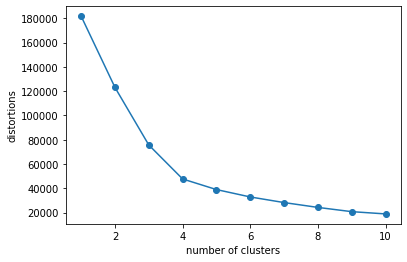

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#使用肘方法选取k值
d=[]
for i in range(1,11):    #k取值1~11，做kmeans聚类，看不同k值对应的簇内误差平方和
    km=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(creditStandardData)
    d.append(km.inertia_)  #inertia簇内误差平方和
#肘处的K即为最佳K值,这里我选的是5
plt.plot(range(1,11),d,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortions')
plt.show()

In [9]:
#构建K-Means聚类模型
from sklearn.cluster import KMeans
k = 5#建议逐渐增加K值，观察分群结果，最终确定最优的K值方案。
kmeans_model = KMeans(n_clusters=k, random_state=100)
fit_kmeans = kmeans_model.fit(creditStandardData)#模型训练

In [10]:
#统计各客户群的数目
r1 = pd.Series(kmeans_model.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(kmeans_model.cluster_centers_) #找出聚类中心
r = pd.concat([r2, r1], axis = 1) 
r.columns = ['历史行为特征', '经济风险特征', '收入风险特征', '类别数目']
print(r)
#经过观察可以发现有明显的5个类群
#1. 经济风险较大的客户
#2. 收入风险较大的客户
#3. 历史行为特征数据很高的用户，应该留意
#4. 同时面临经济风险和收入风险的客户
#5. 低风险客户，他们三个特征都很低

历史行为特征    经济风险特征    收入风险特征   类别数目
0 -0.239388  0.813481 -0.757578  18351
1 -0.224082 -0.931599  1.566541   8651
2  4.024886 -0.028074  0.135765   3399
3 -0.245197  0.829176  0.627385  12381
4 -0.242361 -0.951047 -0.443883  17796
